In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from tqdm import tqdm

import torch
import torch.utils.data
from torch import nn, optim

In [3]:
csr = range(500,1500) 
sr = len(csr) 

# Must rewrite initialization for hls4ml. Models are read based on PyTorch serialization implementation 
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.linear1_activations = torch.tensor([])
        self.linear2_activations = torch.tensor([])
        self.bn_activations = torch.tensor([])
        self.relu1_activations = torch.tensor([])
        self.relu2_activations = torch.tensor([])

        self.hn = sr*2 * 1

        self.linear1 = nn.Linear(sr*2, int(self.hn/8))
        self.relu1 = nn.ReLU()
        self.bn = nn.BatchNorm1d(int(self.hn/8), affine=True)

        self.linear2 = nn.Linear(int(self.hn/8), 2)
        self.relu2 = nn.ReLU()

    def forward(self, sig):
        x = self.linear1(sig)
        self.linear1_activations = torch.cat((self.linear1_activations, x.float()), 0)

        x = self.relu1(x)
        self.relu1_activations = torch.cat((self.relu1_activations, x.float()), 0)
        x = self.bn(x)
        self.bn_activations = torch.cat((self.bn_activations, x.float()), 0)

        x = self.linear2(x)
        self.linear2_activations = torch.cat((self.linear2_activations, x.float()), 0)
        x = self.relu2(x)
        self.relu2_activations = torch.cat((self.relu2_activations, x.float()), 0)
        return x

In [4]:
model = Classifier() 
model.load_state_dict(torch.load("checkpoints/checkpoint_tiny_affine.pth")) 

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
from utils.data import test_loader

In [6]:
# Readout Fidelity
device = 'cpu'
model.eval() 
cc = 0
y_true = torch.tensor([]).to(device)
y_pred = torch.tensor([]).to(device)

with torch.no_grad():
    for data, target in test_loader:
        
        data=data.to(device)
        states = model(data)
        target = target.to(device) 

        val, ind = torch.max(states,1)
        y_pred = torch.cat((y_pred, ind.float()), 0)
        y_true = torch.cat((y_true, target), 0)

acc = y_true-y_pred
# accuracy = (len(y_true)-torch.count_nonzero(acc))/len(y_true)
accuracy = (len(y_true)-(acc==-1).sum().float())/len(y_true)
accuracy = accuracy.item()

print('Readout Fidelity: %', accuracy*100)

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Model Parameters: %', num_parameters)


Readout Fidelity: % 94.80000138282776
Model Parameters: % 501252


### Distribution Weight/Bias

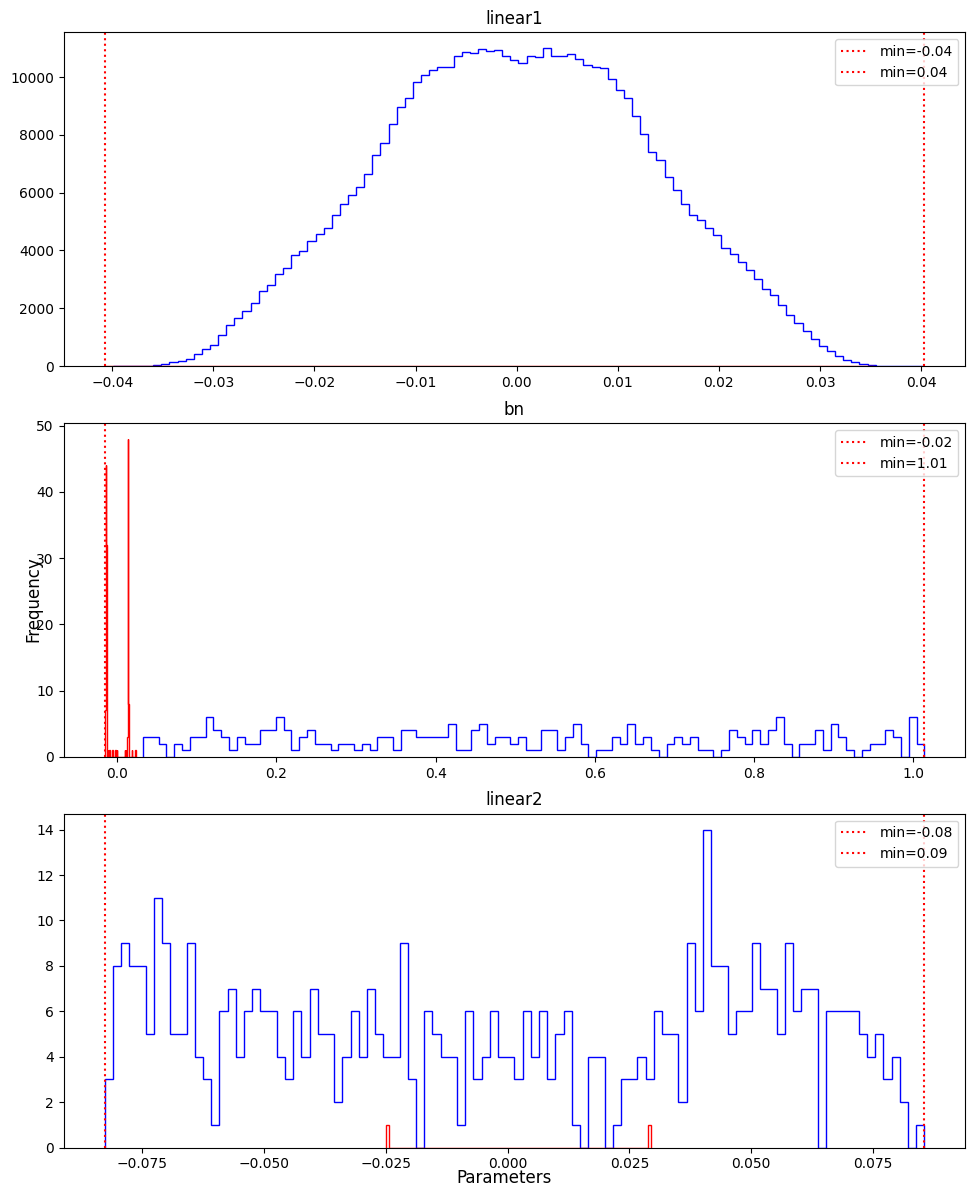

In [7]:
layers = ['linear1', 'bn', 'linear2']

fig, axs = plt.subplots(int(len(layers)), 1, figsize=(10, 12))
fig.tight_layout(pad=2.0)

for idx, layer_name in enumerate(layers):
    try:
        layer = getattr(model, layer_name)
    except Exception as e:
        print(f'Failed retrieving layer {layer}')
        print(e)

    # if isinstance(layer, nn.Linear):
    #     weight_data = layer.weight.data.reshape(-1)
    #     bias_data = layer.bias.data.reshape(-1)
    #     axs[idx].hist(weight_data, bins=100, histtype='step', color='blue')
    #     axs[idx].hist(bias_data, bins=100, histtype='step', color='red')
    # elif isinstance(layer, nn.BatchNorm1d):
    weight_data = layer.weight.data.reshape(-1)
    bias_data = layer.bias.data.reshape(-1)
    axs[idx].hist(layer.weight.data.reshape(-1), bins=100, histtype='step', color='blue')
    axs[idx].hist(layer.bias.data.reshape(-1), bins=100, histtype='step', color='red')

    data_min = min(weight_data.min(), bias_data.min())
    data_max = max(weight_data.max(), bias_data.max())
    axs[idx].axvline(x=data_min, color='red', ls=':', label=f'min={data_min:.2f}')
    axs[idx].axvline(x=data_max, color='red', ls=':', label=f'min={data_max:.2f}')
    
    axs[idx].title.set_text(layer_name)
    axs[idx].legend(loc='upper right')

fig.supxlabel('Parameters')
fig.supylabel('Frequency')
plt.show()

### Distribution of activations

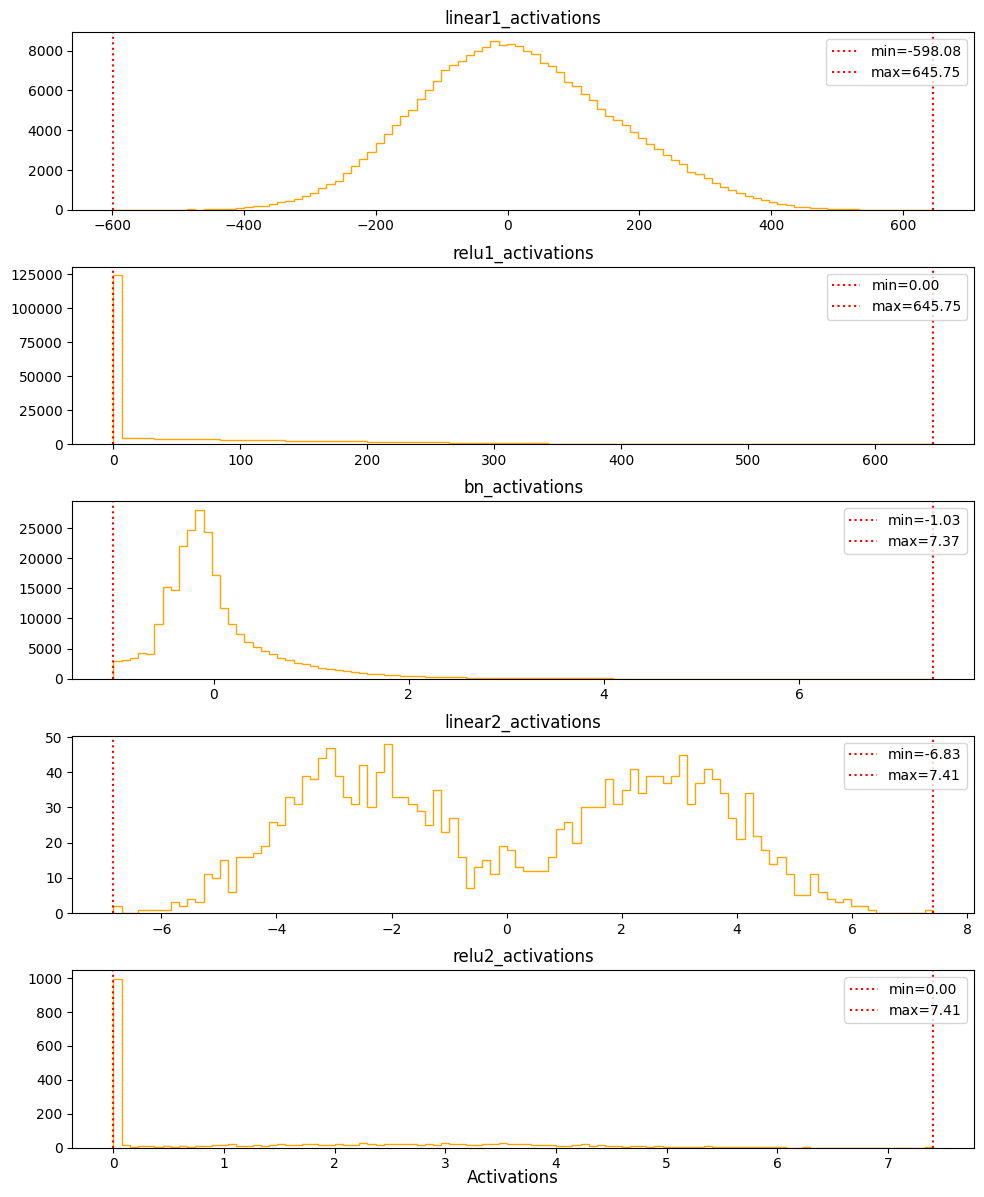

In [8]:
layers = ['linear1_activations', 'relu1_activations', 'bn_activations', 'linear2_activations', 'relu2_activations']

fig, axs = plt.subplots(int(len(layers)), 1, figsize=(10, 12))
fig.tight_layout(pad=2.0)

for idx, layer_name in enumerate(layers):
    try:
        layer = getattr(model, layer_name)
    except Exception as e:
        print(f'Failed retrieving {layer}')
        print(e)

    data = layer.reshape(-1)
    axs[idx].hist(data, bins=100, histtype='step', color='orange')
    axs[idx].axvline(x=data.min(), color='red', ls=':', label=f'min={data.min():.2f}')
    axs[idx].axvline(x=data.max(), color='red', ls=':', label=f'max={data.max():.2f}')
    axs[idx].title.set_text(layer_name)
    axs[idx].legend(loc='upper right')

fig.supxlabel('Activations') 
# fig.supylabel('Frequency') 
plt.show()